In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from collections import defaultdict
import pickle
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english', ignore_stopwords=False)

class StemmedTfidfVectorizer(TfidfVectorizer):    
    def __init__(self, stemmer, *args, **kwargs):
        super(StemmedTfidfVectorizer, self).__init__(*args, **kwargs)
        self.stemmer = stemmer
        
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (self.stemmer.stem(word) for word in analyzer(doc.replace('\n', ' ')))

#Read data
data_file = "/Users/phuong/Documents/skr-consort-master/datasets/clean_data_file.csv"
data_df = pd.read_csv(data_file, encoding = "latin")

#generate categorize_id level 3 based on Second Label
data_df['CONSORT_Item_to_id'] = data_df['CONSORT_Item'].factorize()[0]
CONSORT_Item_to_id = data_df[['CONSORT_Item', 'CONSORT_Item_to_id']].drop_duplicates().sort_values('CONSORT_Item_to_id')
CONSORT_to_id = dict(CONSORT_Item_to_id.values)
    
#Get tfidf from Title. Abstract, Methods Section
text = data_df['clean_sentence_text']
tfidf = StemmedTfidfVectorizer(stemmer=stemmer, sublinear_tf=True, ngram_range=(1, 1))
features_fit = tfidf.fit(text)
features = features_fit.transform(text)
labels = data_df['CONSORT_Item_to_id']


#Analyze correlation between unigram and labels
N= 27
for label_name, label_id in sorted(CONSORT_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigram = [v for v in feature_names if len(v.split(' ')) == 1]
    print ("# '{}':".format(label_name))
    print ("  . Most correlated bigrams:\n. {}".format('\n. '.join(unigram[-N:])))


# '0':
  . Most correlated bigrams:
. intent
. studi
. local
. supplement
. full
. monitor
. censor
. review
. declar
. role
. access
. author
. all
. helsinki
. submit
. interpret
. data
. public
. write
. board
. gave
. committe
. ethic
. inform
. approv
. written
. consent
# '10':
  . Most correlated bigrams:
. karyotyp
. hsb
. insid
. phb
. identif
. phone
. envelop
. hormon
. secur
. voic
. counsellor
. aberdeen
. alloc
. telephon
. system
. print
. eighteen
. fax
. communic
. randomis
. kept
. bolus
. follicl
. web
. uniqu
. internet
. utrecht
# '11a':
  . Most correlated bigrams:
. unbias
. remain
. caregiv
. clinician
. manner
. true
. biologist
. resourc
. clean
. 276
. surgeon
. guess
. assign
. criteria1
. irrevoc
. adjud
. physician
. neither
. awar
. neurologist
. unawar
. investig
. personnel
. alloc
. staff
. blind
. mask
# '11b':
  . Most correlated bigrams:
. dr
. falk
. monzes
. cant
. cilag
. cc
. imp
. janssen
. eprex
. cologno
. pierrel
. distinguish
. mdis
. exter

/Users/phuong/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:167: RuntimeWarning: divide by zero encountered in true_divide
  chisq /= f_exp


Accuracy: 0.5757575757575758
Precision: 0.5970651426147761
Recall: 0.5757575757575758
F1 score: 0.5614898607289422
              precision    recall  f1-score   support

           0       0.32      0.46      0.37        13
           1       0.68      0.40      0.50       126
           2       0.17      0.25      0.20         8
           3       0.00      0.00      0.00         5
           4       0.78      0.66      0.71        32
           5       0.18      0.22      0.20         9
           6       0.33      0.30      0.32        10
           7       0.68      0.46      0.55        54
           8       0.58      0.92      0.71       131
           9       0.64      0.63      0.64        54
          10       0.23      0.36      0.28        14
          11       0.60      0.75      0.67         4
          12       0.50      0.33      0.40         3
          13       0.00      0.00      0.00         1
          14       1.00      0.91      0.95        23
          15       0

/Users/phuong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/phuong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/phuong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/phuong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

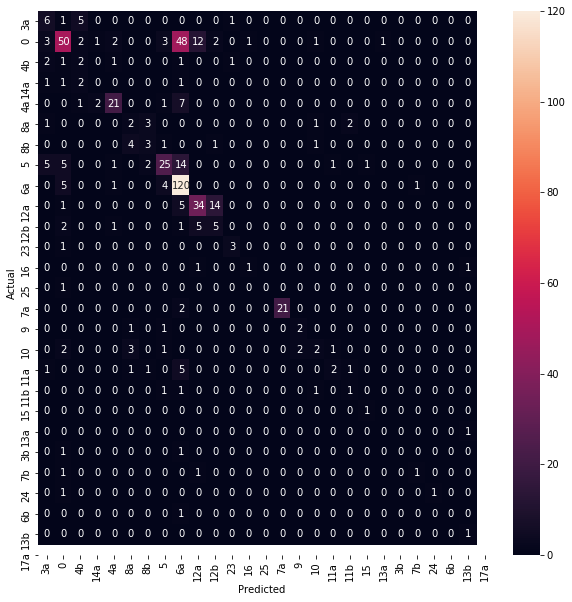

In [20]:
#Classifier development
 
chi_squarer_multiclass = SelectKBest(chi2, k=2000)

#Train multi-class SVM model 
X_train, X_test, y_train, y_test,  = train_test_split(features, labels, stratify = labels, test_size=0.2, random_state = 0)
model_multiclass = SVC(kernel='linear', class_weight='balanced')
clf_pipe_multiclass = Pipeline([('chi_sq', chi_squarer_multiclass), ('model', model_multiclass)])
clf_multiclass = clf_pipe_multiclass.fit(X_train, y_train)
predictions_multiclass = clf_multiclass.predict(X_test)

#Print Accurancy, ROC AUC, F1 Scores, Recall, Precision)
print ('Accuracy:', accuracy_score(y_test, predictions_multiclass))
print ('Precision:', precision_score(y_test, predictions_multiclass,average='weighted'))
print ('Recall:', recall_score(y_test, predictions_multiclass,average='weighted'))
print ('F1 score:', f1_score(y_test, predictions_multiclass,average='weighted'))
print (classification_report(y_test,predictions_multiclass))

conf_mat = confusion_matrix(y_test, predictions_multiclass)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=CONSORT_Item_to_id['CONSORT_Item'].values, yticklabels=CONSORT_Item_to_id['CONSORT_Item'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()